# Import required packages

In [3]:
import xarray as xr                                                  # handles gridded data
import numpy as np                                                   # numerical functions etc
import pandas as pd                                                  # handles tables of data (.csv, spreadsheets etc)
import re                                                            # allows manipulation of text strings

import matplotlib                                                    # plotting functions generally
import matplotlib.pyplot as plt                                      # specific plotting function we'll use a lot, so we'll give it a shorter name
from matplotlib.patches import Rectangle                             # specific plotting function with an annoyingly long name

import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

import cartopy                                                       # plotting geographical features
import regionmask                                                    # convert shapefile to binary 0,1 mask
import geopandas as gpd                                              # shapefiles

from geopy.geocoders import Nominatim                                # get lat & lon coordinates from a place name
from dateutil.relativedelta import relativedelta                     # calculate differences in times (needed to decode weird timestamps)

# you might get an error like 'ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/anaconda3/envs/wwa/share/proj failed' - you can ignore this!

# Useful functions

In [4]:
def wrap_lon(ds):
    
    # 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def decode_times(ts):
    
    # manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def get_latlon(city):
    
    # retrieve lat & lon for given place name
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def doy_axes(ax = None):

    # make nicer axis labels when you're plotting against day of year
    if ax is None: ax = plt.gca()
    
    # define axis labels for DOY plotting
    days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
    lineticks = [i+1 for i in range(366) if (days[i].day) == 1]
    labelticks = [i+1 for i in range(366) if (days[i].day) == 16]
    labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 16]

    # actually draw the axes & gridlines
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.1, lw = 1) for x in lineticks]
    ax.set_xlabel("")

# Load & plot gridded data

In [5]:
# open a dataset
xr.open_dataset("era5_tp_daily_eu_extended_10.7-25E_46-52.3N_1950-2024_su.nc") # change filename to use different data

<xarray.Dataset> Size: 165MB
Dimensions:  (time: 27292, lon: 58, lat: 26)
Coordinates:
  * time     (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-09-20
  * lon      (lon) float32 232B 10.75 11.0 11.25 11.5 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 104B 52.25 52.0 51.75 51.5 ... 46.75 46.5 46.25 46.0
Data variables:
    tp       (time, lat, lon) float32 165MB ...
Attributes: (12/21)
    title:                      subset of "ERA5 reanalysis, https://www.ecmwf...
    Conventions:                CF-1.0
    source_field:               https://climexp.knmi.nl/select.cgi?field=era5...
    cdi:                        Climate Data Interface version 2.4.0 (https:/...
    institution:                KNMI Climate Explorer and European Centre for...
    frequency:                  day
    ...                         ...
    time_coverage_start:        1950-01-01
    time_coverage_end:          2024-08-31
    climexp_url:                https://climexp.knmi.nl/select.cgi?era5_tp_da...
    cdo:                        Climate Data Operators version 2.4.0 (https:/...
    scripturl01:                http://climexp.knmi.nl/get_index.cgi?email=db...
    history:                     2024-09-17  8:38:38 ./bin/get_index ERA5/era...

In [6]:
# load the data and select just the total precipitation (tp), call it 'ds'
ds = xr.open_dataset("era5_tp_daily_eu_extended_10.7-25E_46-52.3N_1950-2024_su.nc").tp

## Plot a single day

We can use the inbuilt plotting function to get a quick overview of the data

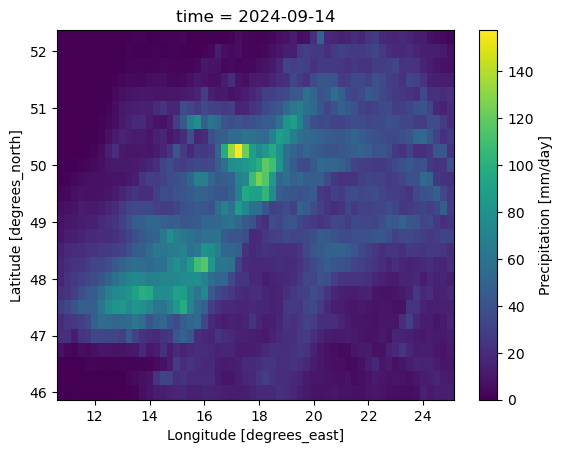

In [7]:
ds.sel(time = "2024-09-14").plot()

We can change the colour mapping to suit that hazard that we're looking at (https://matplotlib.org/stable/users/explain/colors/colormaps.html)  
For example, `RdBu_r` (Red-blue reversed) is good for temperatures
`YlGnBu` (Yellow-green) is good for precipitation

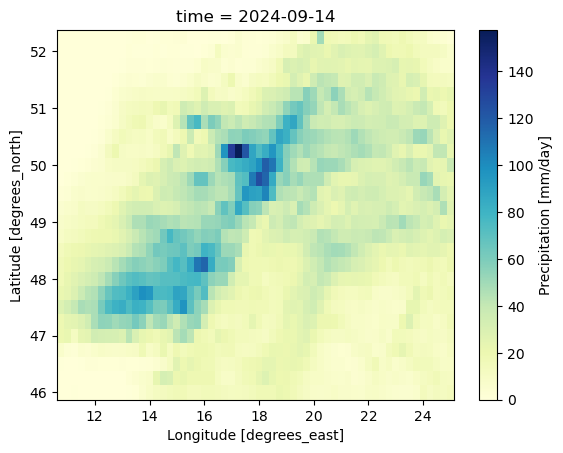

In [8]:
ds.sel(time = "2024-09-14").plot(cmap = "YlGnBu")

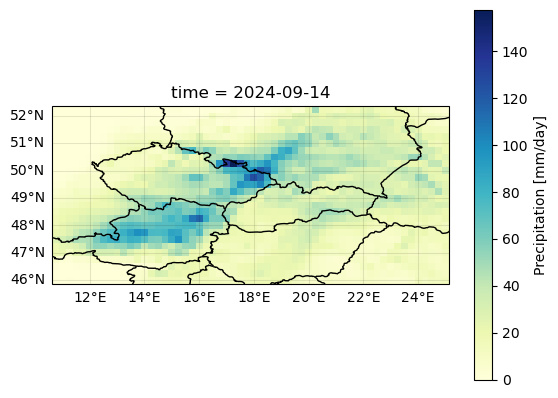

In [9]:
# we can add country borders and gridlines to get a better sense of the area that we're looking at
# first we need to specify which map projection we want to plot on, and call the figure 'fig' so that we can add elements to it
fig = ds.sel(time = "2024-09-14").plot(cmap = "YlGnBu", 
                                       subplot_kws = {"projection" : cartopy.crs.PlateCarree()})

# then add borders & gridlines
fig.axes.add_feature(cartopy.feature.BORDERS)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

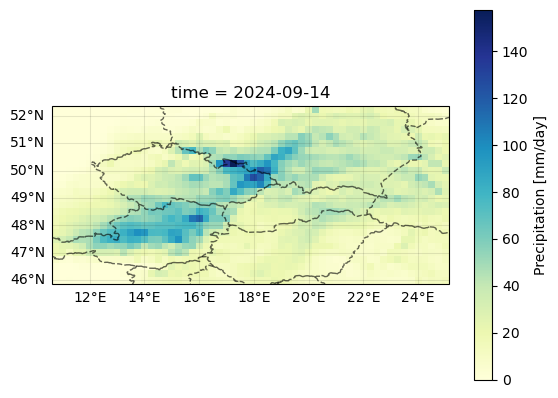

In [10]:
# we can change the opacity & style of the national boundaries
fig = ds.sel(time = "2024-09-14").plot(cmap = "YlGnBu", 
                                       subplot_kws = {"projection" : cartopy.crs.PlateCarree()})

fig.axes.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

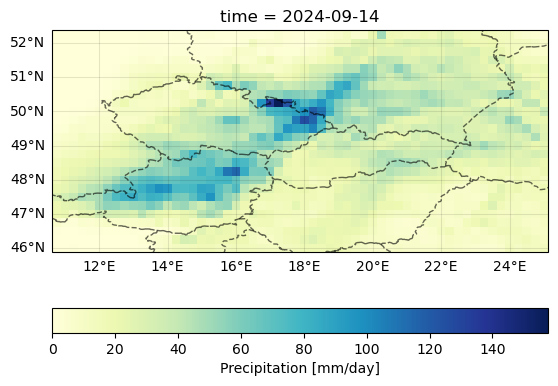

In [11]:
# we can also move the scale bar to somewhere more aesthetically pleasing
fig = ds.sel(time = "2024-09-14").plot(cmap = "YlGnBu", 
                                       subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                       cbar_kwargs = {"location" : "bottom"})

fig.axes.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

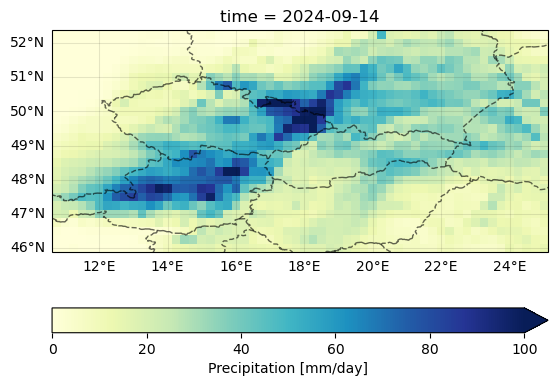

In [12]:
# we can change the min & max values on the scale to highlight the event more strongly
fig = ds.sel(time = "2024-09-14").plot(cmap = "YlGnBu", 
                                       subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                       cbar_kwargs = {"location" : "bottom"},
                                       vmin = 0, vmax = 100)

fig.axes.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

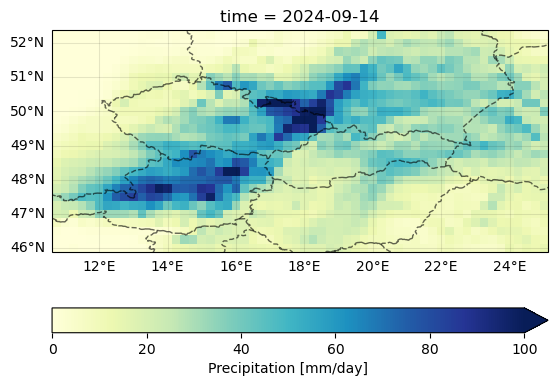

In [13]:
# when we're happy with the plot, we can save it as a .png file
fig = ds.sel(time = "2024-09-14").plot(cmap = "YlGnBu",     # colour scheme to use for plotting
                                       subplot_kws = {"projection" : cartopy.crs.PlateCarree()},     # tell it which projection to use
                                       cbar_kwargs = {"location" : "bottom"},
                                       vmin = 0, vmax = 100)

fig.axes.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

plt.savefig("era5-rainfall-sep14.png", bbox_inches = "tight")

## Add country labels

In [14]:
# define the region that we want to look at
xn,xx,yn,yx = [10.7,25,46,52.3]

# get dataframe of countries (predefined with 'regionmask' package)
gdf = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.to_geodataframe()

# replace country outlines with central point
gdf.geometry = gdf.representative_point()

# clip countries to the study area
gdf = gdf.clip((xn,yn,xx,yx))

In [15]:
gdf

abbrevs     names                   geometry
numbers                                             
117          RO   Romania  POINT (24.21169 46.03603)
115          HU   Hungary   POINT (19.10325 47.2452)
152          SK  Slovakia  POINT (19.63011 48.71194)
113          PL    Poland  POINT (19.07627 51.88442)
150         SLO  Slovenia  POINT (14.73228 46.12744)
114           A   Austria  POINT (14.95315 47.91918)
153          CZ   Czechia  POINT (15.53817 49.75827)

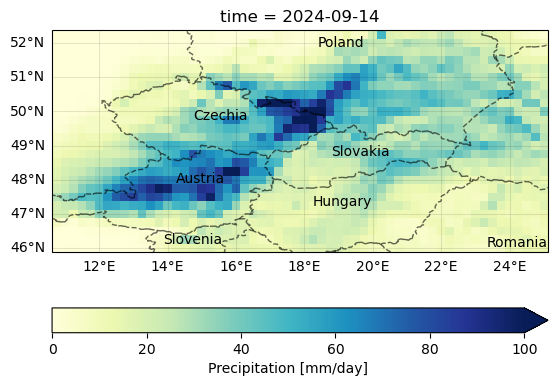

In [16]:
fig = ds.sel(time = "2024-09-14").plot(cmap = "YlGnBu",
                                       subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                       cbar_kwargs = {"location" : "bottom"},
                                       vmin = 0, vmax = 100)

fig.axes.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

# we have to loop over the rows in the list of points & country names
for idx, r in gdf.iterrows():
     fig.axes.annotate(text = r['names'], xy = (r.geometry.x, r.geometry.y), horizontalalignment = 'center')

## Plot several days

We can also plot a series of days in one go:

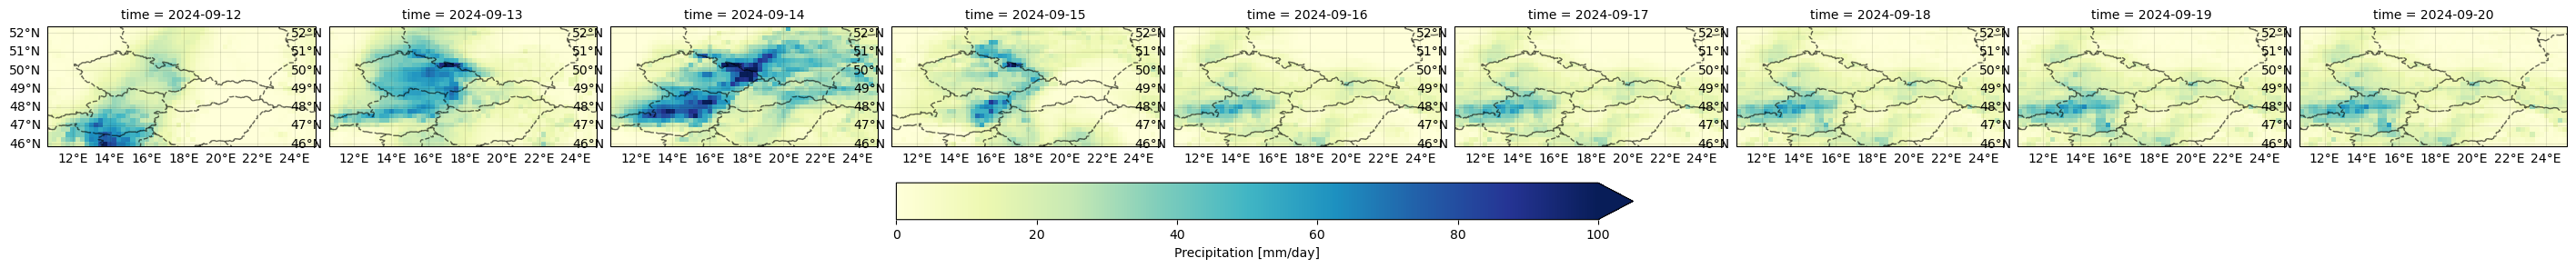

In [17]:
fig = ds.sel(time = slice("2024-09-12", None)).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom"},
                                                    vmin = 0, vmax = 100,
                                                    col = "time")     # we have to tell Python which axis to display

# this time, we have to add the borders and gridlines to each panel individually
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

These figures are very small - we can rearrange to make them larger

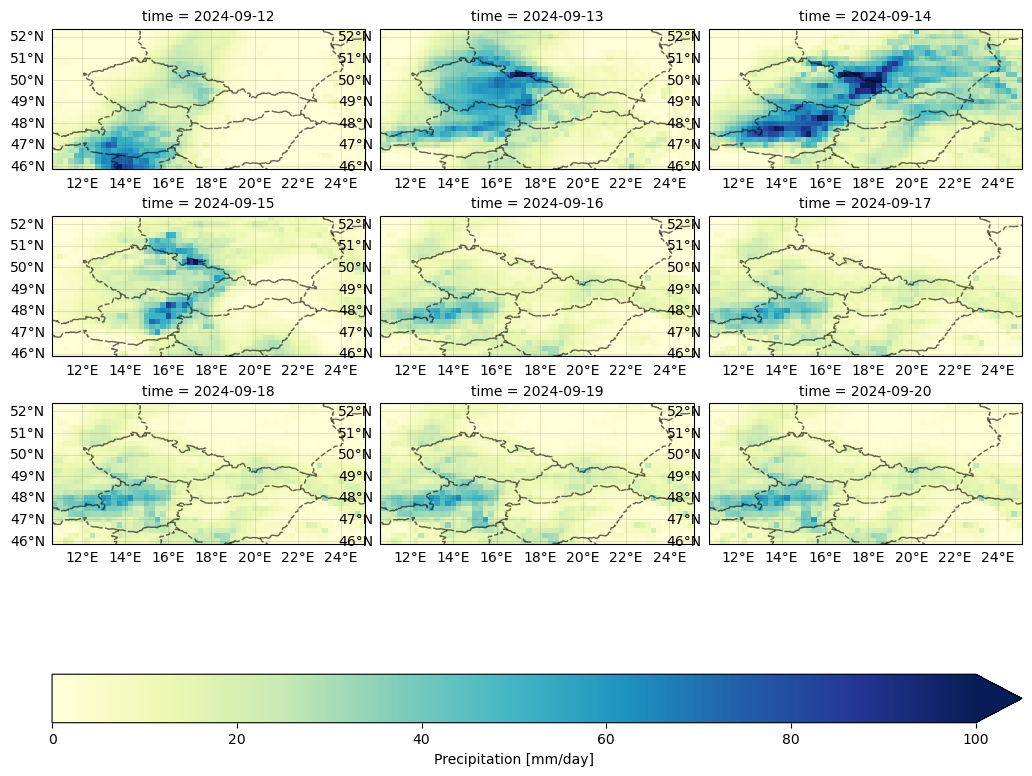

In [18]:
fig = ds.sel(time = slice("2024-09-12", None)).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom"},
                                                    vmin = 0, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3)     # only put 3 panels on each row

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

Now the labels are overlapping - we can fix this too!

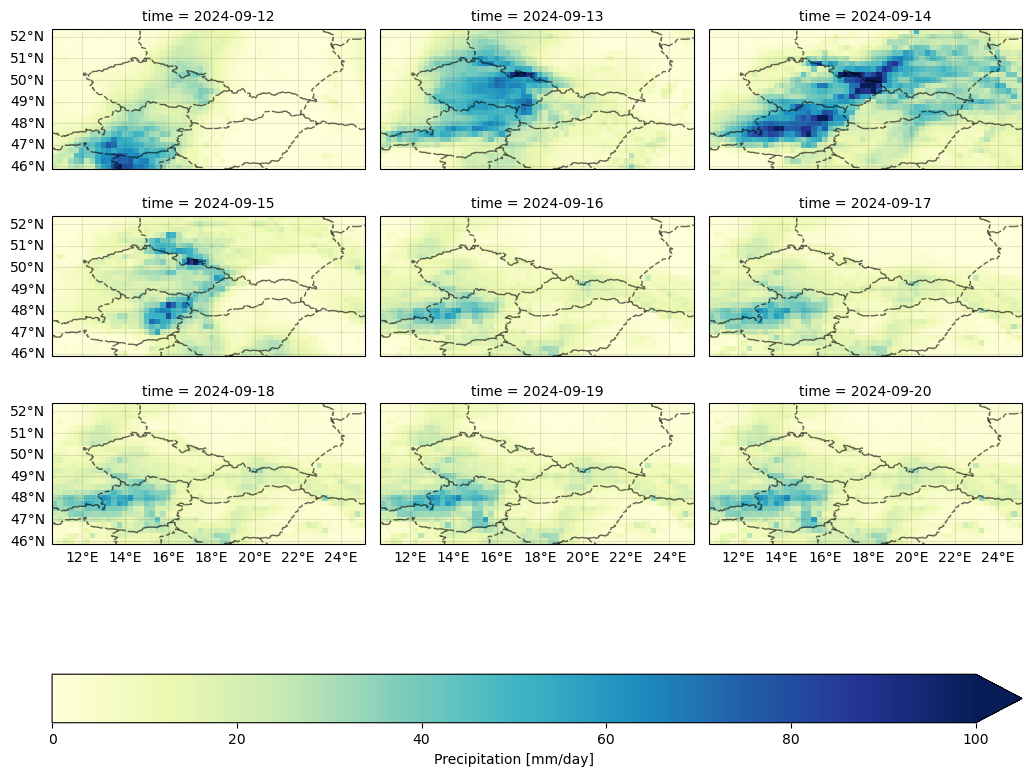

In [19]:
fig = ds.sel(time = slice("2024-09-12", None)).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom"},
                                                    vmin = 0, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)


# only put the y-labels on the leftmost column (Python indexing starts at 0)
for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
    
# only put the x-labels on the bottom row (item -1 is the last item in a list)
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

We can also resize the plot scale

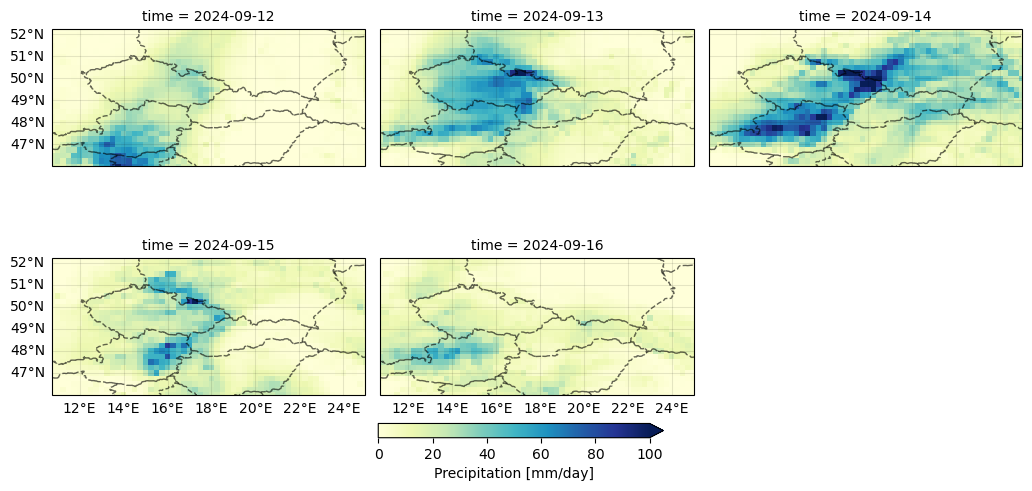

In [20]:
fig = ds.sel(time = slice("2024-09-12", "2024-09-16")).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                                   "extent" : (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max())}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.025, "pad" : 0.05}, # 'fraction' changes the size of the scale bar, 'pad' changes the distance to the plots
                                                    vmin = 0, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3,
                                                    size = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

## Add sites where impacts occurred

In [21]:
# make a list of the locations where impacts were reported
affected_sites = ["Vienna", "Graz", "Glucholazy", "Litovel", "Lower Austria"]
px = pd.DataFrame([get_latlon(s) for s in affected_sites])

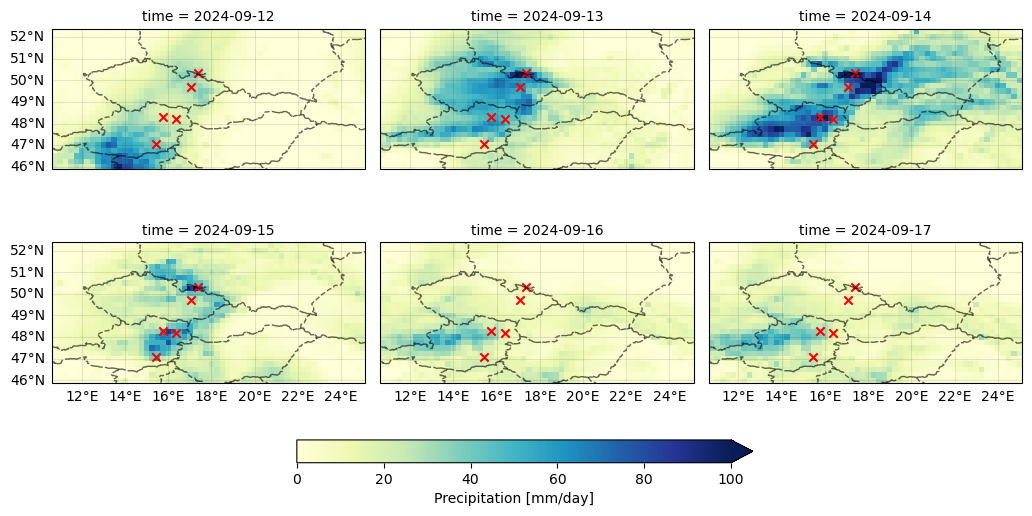

In [22]:
fig = ds.sel(time = slice("2024-09-12", "2024-09-17")).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1}, # 'fraction' changes the size of the scale bar, 'pad' changes the distance to the plots
                                                    vmin = 0, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    # ax.add_feature(cartopy.feature.RIVERS, alpha = 0.6, color = "blue")
    # ax.add_feature(cartopy.feature.LAKES, alpha = 0.6, color = "blue")
    ax.gridlines(color = "k", alpha = 0.1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "red")               # add points where impacts were reported

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

# Other features to consider

## Elevation
Source data: http://research.jisao.washington.edu/data_sets/elevation/

In [23]:
# load the elevation data
elev = xr.open_dataset("elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data

# convert longitudes from 0:360 to -180:180
elev = wrap_lon(elev)

# define the region we want to look at
study_region = {"lon" : slice(10.7, 24), "lat" : slice(46, 52.3)}

# trim the elevation data to just that region
elev = elev.sel(study_region)

/home/cb2714/miniconda3/envs/NEW/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


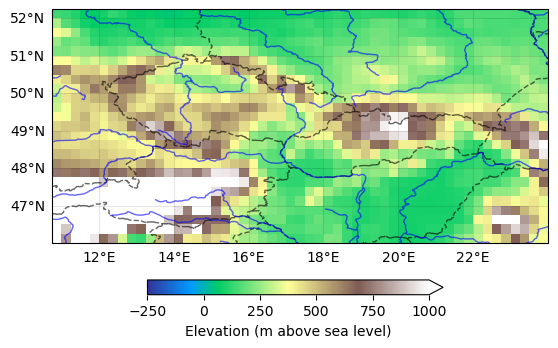

In [24]:
# we can plot the elevation data to match the precipitation data
fig = elev.plot(cmap = "terrain", vmin = -250, vmax = 1000,                      # aim to keep vmin:vmax at -1:4 ratio to keep change from blue to green at zero
                subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1, "label" : "Elevation (m above sea level)"})    # can also relabel scale bar

# add borders & gridlines as before
fig.axes.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
fig.axes.add_feature(cartopy.feature.RIVERS, alpha = 0.6, color = "blue")

## Koppen-Geiger climatology

Standard classification of climatologies. Source data: https://www.gloh2o.org/koppen/

In [25]:
# we can load the data and select the study region in a single
kg = xr.open_dataset("kg_classifications.nc").kg_cat.sel(study_region)

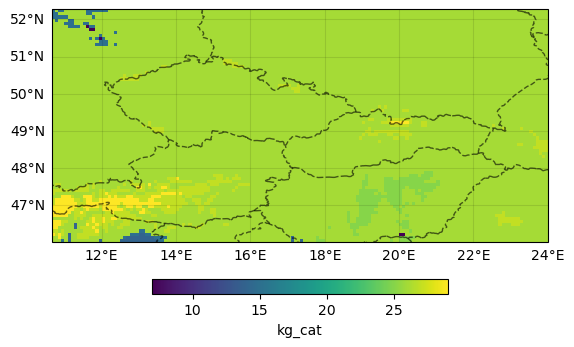

In [26]:
fig = kg.plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
              cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1})

# add borders & gridlines as before
fig.axes.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
fig.axes.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

In [27]:
# check what these classifications mean
kg_cats = pd.read_csv("kg_legend.csv", index_col = "cat")
cats_on_map = np.unique(kg.values).tolist()
kg_cats.loc[cats_on_map]

code                                   desc
cat                                            
7    BSk                     Arid, steppe, cold
14   Cfa   Temperate, no dry season, hot summer
15   Cfb  Temperate, no dry season, warm summer
25   Dfa        Cold, no dry season, hot summer
26   Dfb       Cold, no dry season, warm summer
27   Dfc       Cold, no dry season, cold summer
29    ET                          Polar, tundra

# Identify the region we want to look at

## Plot daily anomalies

In [28]:
# select September rainfall only
ds_sep = ds.groupby("time.month")[9]

In [29]:
ds_sep

<xarray.DataArray 'tp' (time: 2240, lat: 26, lon: 58)> Size: 14MB
[3377920 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 18kB 1950-09-01 1950-09-02 ... 2024-09-20
  * lon      (lon) float32 232B 10.75 11.0 11.25 11.5 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 104B 52.25 52.0 51.75 51.5 ... 46.75 46.5 46.25 46.0
Attributes:
    long_name:  Precipitation
    units:      mm/day

In [30]:
# calculate the mean daily rainfall during September from 1990-2020
ds_clim = ds_sep.sel(time = slice("1990", "2020")).mean("time")

In [31]:
# calculate the 2024 daily anomalies with respect to September climatology
ds_anom = ds.sel(time = "2024") - ds_clim

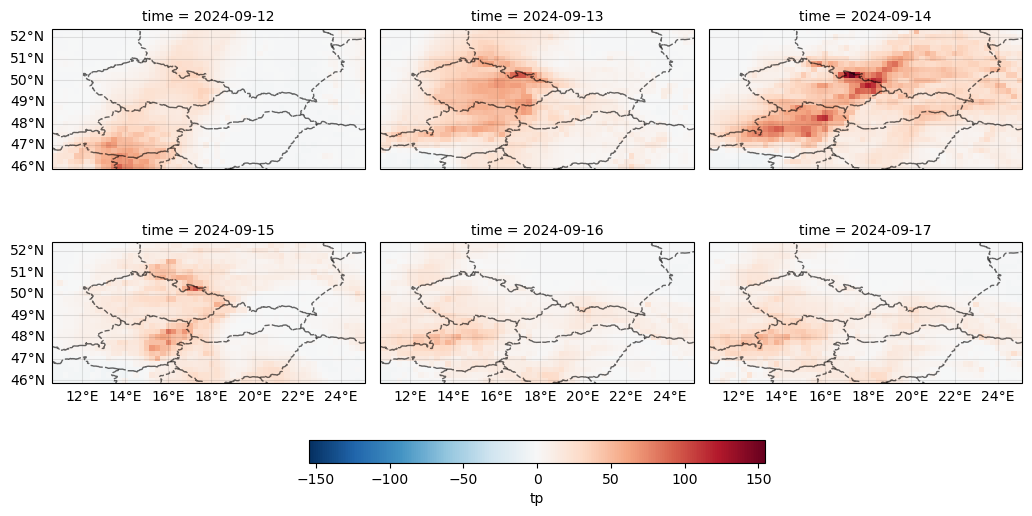

In [32]:
# the colour scale above isn't a great choice for anomalies - we should use a divergent colourmap (Python will suggest a default)
fig = ds_anom.sel(time = slice("2024-09-12", "2024-09-17")).plot(#cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1}, # 'fraction' changes the size of the scale bar, 'pad' changes the distance to the plots
                                                    #vmin = 0, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

    # ax.scatter(px.lon, px.lat, marker = "x", color = "red")               # add points where impacts were reported

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

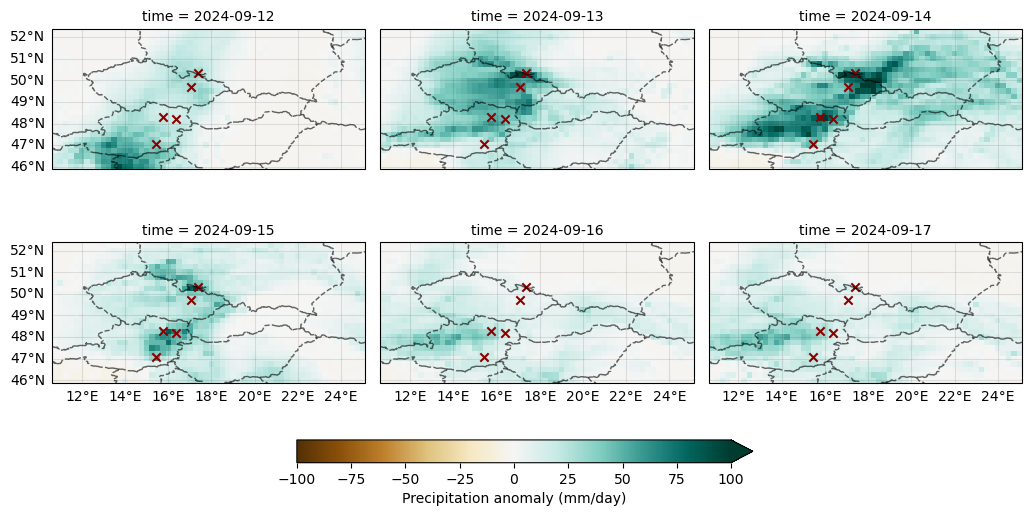

In [33]:
# or we can choose our own colour scheme (and also add a meaningful label to the scale)
fig = ds_anom.sel(time = slice("2024-09-12", "2024-09-17")).plot(cmap = "BrBG",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1, "label" : "Precipitation anomaly (mm/day)"},
                                                    vmin = -100, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "darkred")               # add points where impacts were reported

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

## Plot accumulated rainfall

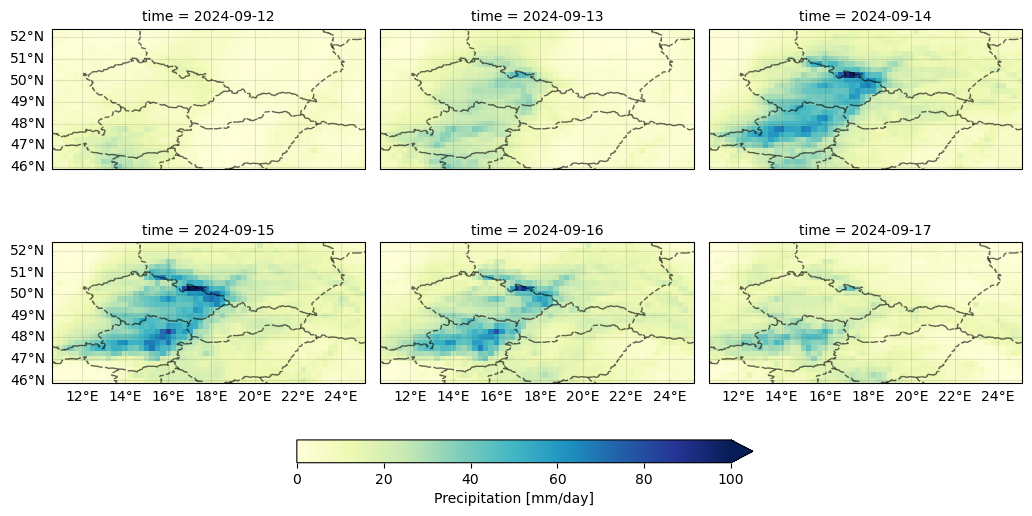

In [34]:
ds_3day = ds.rolling(time = 3, center = False).mean() # 3-day rolling mean

fig = ds_3day.sel(time = slice("2024-09-12", "2024-09-17")).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1}, # 'fraction' changes the size of the scale bar, 'pad' changes the distance to the plots
                                                    vmin = 0, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

Text(0.5, 0.85, '3-day rolling average of daily rainfall')

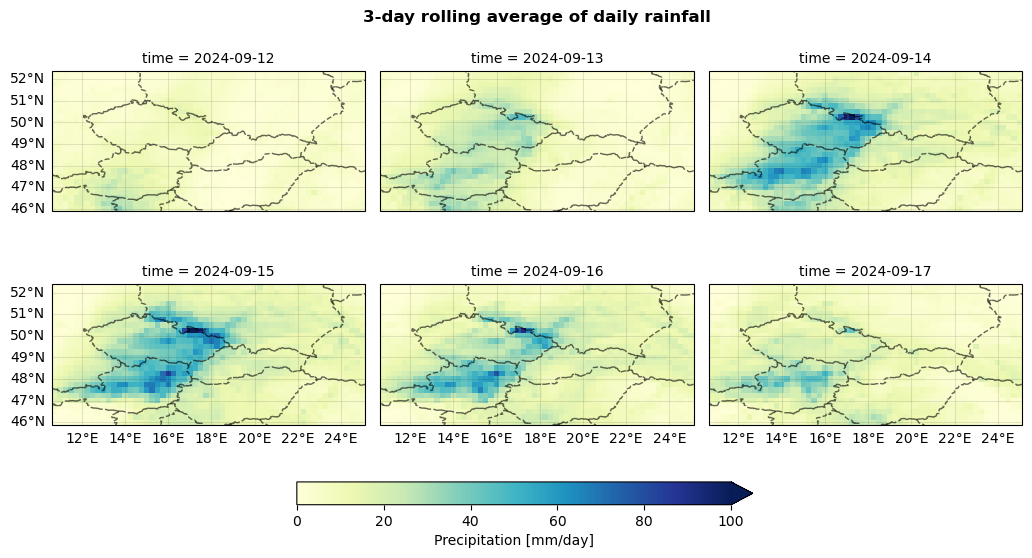

In [35]:
# let's add a title so we remember that this is the 3-day average
ds_3day = ds.rolling(time = 3).mean()

fig = ds_3day.sel(time = slice("2024-09-12", "2024-09-17")).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1}, # 'fraction' changes the size of the scale bar, 'pad' changes the distance to the plots
                                                    vmin = 0, vmax = 100,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

plt.suptitle("3-day rolling average of daily rainfall", fontweight = "bold", y = 0.85)

## Choose the area we want to average over

Text(0.5, 0.85, '3-day rolling average of daily rainfall')

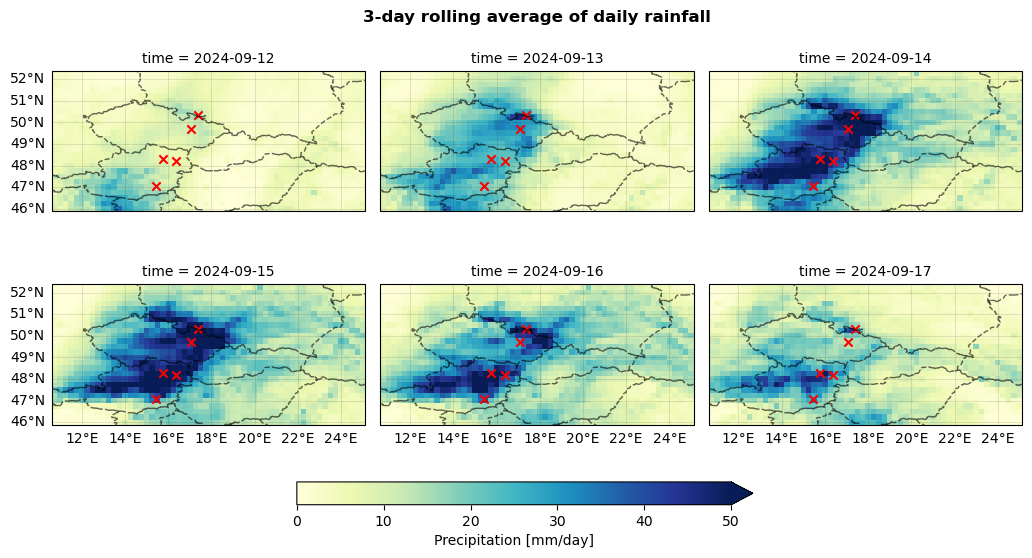

In [36]:
# add points where impacts were reported

ds_3day = ds.rolling(time = 3).mean()

fig = ds_3day.sel(time = slice("2024-09-12", "2024-09-17")).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1}, # 'fraction' changes the size of the scale bar, 'pad' changes the distance to the plots
                                                    vmin = 0, vmax = 50,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)
    ax.scatter(px.lon, px.lat, marker = "x", color = "red")

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

plt.suptitle("3-day rolling average of daily rainfall", fontweight = "bold", y = 0.85)

Text(0.5, 0.85, '3-day rolling average of daily rainfall')

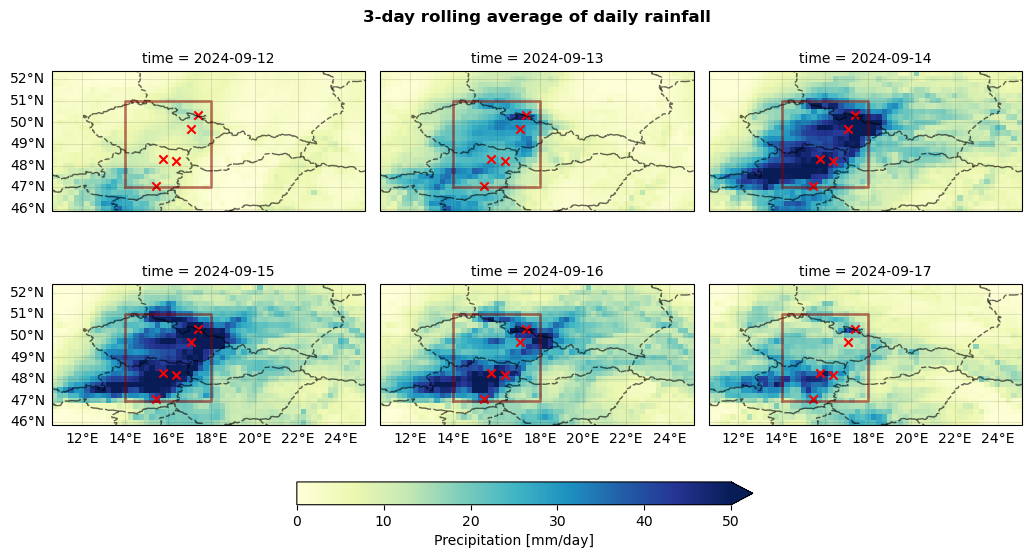

In [37]:
# we can draw a smaller box around the wettest region
xn,xx,yn,yx = [14,18,47,51]

ds_3day = ds.rolling(time = 3).mean()

fig = ds_3day.sel(time = slice("2024-09-12", "2024-09-17")).plot(cmap = "YlGnBu",
                                                    subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1}, # 'fraction' changes the size of the scale bar, 'pad' changes the distance to the plots
                                                    vmin = 0, vmax = 50,
                                                    col = "time",
                                                    col_wrap = 3)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)
    ax.scatter(px.lon, px.lat, marker = "x", color = "red")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

plt.suptitle("3-day rolling average of daily rainfall", fontweight = "bold", y = 0.85)

## Average the precip over the whole box

In [38]:
# extract the chosen region and compute spatial average
pr_subset = ds.sel(lon = slice(xn,xx), lat = slice(yn,yx))
pr_subset

<xarray.DataArray 'tp' (time: 27292, lat: 0, lon: 17)> Size: 0B
array([], shape=(27292, 0, 17), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-09-20
  * lon      (lon) float32 68B 14.0 14.25 14.5 14.75 ... 17.25 17.5 17.75 18.0
  * lat      (lat) float32 0B 
Attributes:
    long_name:  Precipitation
    units:      mm/day

In [39]:
# the data from the Climate Explorer has latitudes in descending order - we can fix this
ds = wrap_lon(ds)

In [40]:
# extract the chosen region and compute spatial average
ts = ds.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])
ts

<xarray.DataArray 'tp' (time: 27292)> Size: 109kB
array([1.6664551e-04, 4.0835710e+00, 5.2132764e+00, ..., 1.6287464e+01,
       1.7029284e+01, 1.7133242e+01], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-09-20

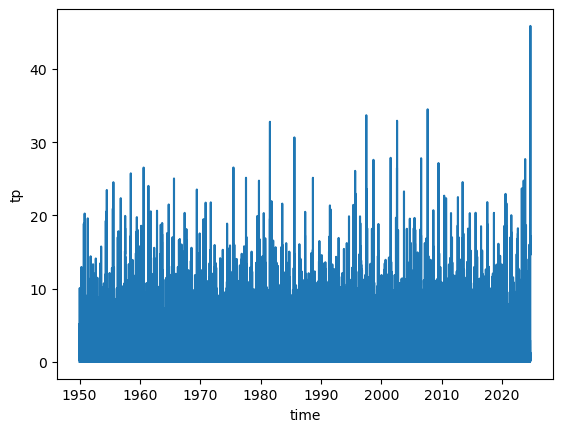

In [41]:
# python can also automatically plot this data for us
ts.plot()

In [42]:
# let's save the time series before we go any further
ts.to_netcdf("pr-timeseries.nc")

# Other ways to select a region

## Using a predefined region

The `regionmask` package provides predefined shapefiles for countries, US states and coastlines - we can use these to create a mask that allows us to select just one country, for example

In [ ]:
# first, we load the regionmask so that we can manipulate it
gdf = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe()
gdf

In [ ]:
# then we can select a single country
gdf_A = gdf.loc[gdf.names == "Czechia"]
gdf_A.plot()

In [ ]:
# and we can use this to create a regionmask for our dataset `ds` by selecting only points that lie within the selected region
rm = regionmask.mask_geopandas(gdf_A, ds.lon, ds.lat)
rm.plot()

In [ ]:
# Finally, we can select just the country we're interested in, and average over that
ts_A = ds.where(~np.isnan(rm)).mean(["lat", "lon"])
ts_A.plot()

## Using a shapefile

A 'shapefile' is just a collection of points and shapes defining a region, stored as a set of specific files that have to be loaded together.  
Fortunately, Python can handle this for us as long as we remember to download all the bits of the shapefile.

Handy sources for shapefiles (or you can find almost anything if you google for long enough):
- [The Humanitarian Data Exchange](https://data.humdata.org/dataset?ext_subnational=1&ext_administrative_divisions=1&q=&sort=if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc&ext_page_size=25) has shapefiles for lots of administrative regions in different countries
- [Hydrobasins](https://www.hydrosheds.org/products/hydrobasins) provides nested river basins - you'll have to play around to figure out which 'layer' you need, I usually start at 4 (scroll right down to the bottom to download per continent and start with levels 1-6, the files are much smaller)
- [Natural Earth](https://www.naturalearthdata.com/features/) has both political and physical shapefiles

When you download a shapefile, put all the files into a single folder and tell Python to open that folder.

In [ ]:
xn,xx,yn,yx = [10.7,25,46,52.3]

In [ ]:
sf_hybas05 = gpd.read_file("sf_hybas05/").clip((xn,yn,xx,yx))
sf_hybas05.boundary.plot()

In [ ]:
sf_hybas04 = gpd.read_file("sf_hybas04/").clip((xn,yn,xx,yx))
fig = sf_hybas04.boundary.plot()

# we can plot just one of the shapes at a time to decide which one we want to use
sf_hybas04.iloc[[10,12]].plot(ax = fig.axes)

In [ ]:
sf_hybas04 = gpd.read_file("sf_hybas04/").clip((xn,yn,xx,yx))
fig = sf_hybas04.boundary.plot()

# we can plot just one of the shapes at a time to decide which one(s) we want to use
sf_hybas04.iloc[[12]].plot(ax = fig.axes)

In [ ]:
# select the regions we're interested in
sf = sf_hybas04.iloc[[10,12]]

In [ ]:
# we can turn these into a single polygon if we want to
sf = sf.dissolve().boundary
sf.plot()

# Working with time series

In [5]:
# remember that time series we created from the box?
ts = xr.open_dataset("pr-timeseries.nc").tp
ts

<xarray.DataArray 'tp' (time: 27292)> Size: 109kB
[27292 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-09-20

## Smoothed seasonal cycle

In [9]:
# first we smooth the daily time series (for temperatures you could use a shorter window, or even no smoothing)
sm_days = 15
ts_sm = ts.rolling(time = sm_days, center = True).mean()

In [10]:
# then we select the time period to compute the climatology
ts_clim = ts_sm.sel(time = slice("1990", "2020"))

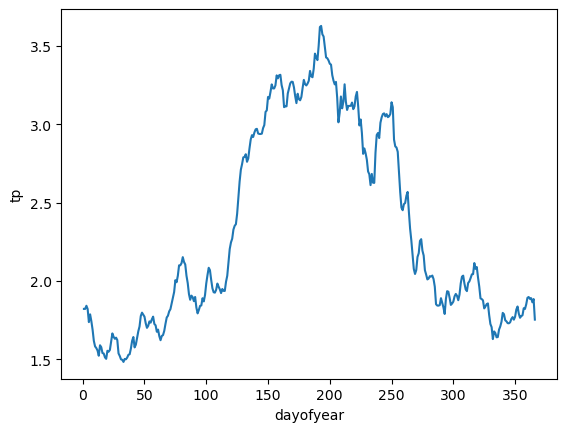

In [11]:
# then average over each day of the year and plot
ts_clim.groupby("time.dayofyear").mean().plot()

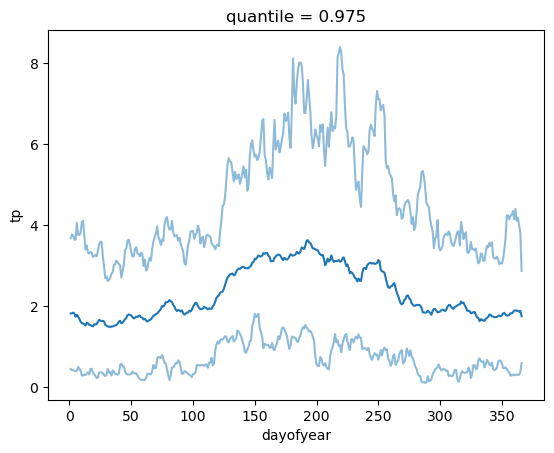

In [12]:
# we can also add quantiles
ts_clim.groupby("time.dayofyear").mean().plot()
ts_clim.groupby("time.dayofyear").quantile(0.025).plot(color = "tab:blue", alpha = 0.5)   # lower bound of the central 95%
ts_clim.groupby("time.dayofyear").quantile(0.975).plot(color = "tab:blue", alpha = 0.5)   # lower bound of the central 95%

Text(0, 0.5, 'Precipitation (mm/day)')

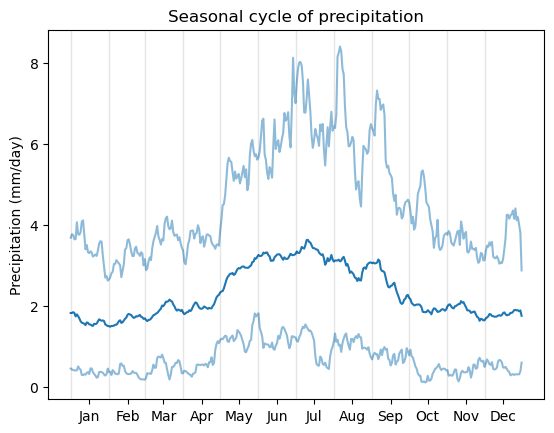

In [13]:
# clean up the axes
ts_clim.groupby("time.dayofyear").mean().plot()
ts_clim.groupby("time.dayofyear").quantile(0.025).plot(color = "tab:blue", alpha = 0.5)   # lower bound of the central 95%
ts_clim.groupby("time.dayofyear").quantile(0.975).plot(color = "tab:blue", alpha = 0.5)   # lower bound of the central 95%

ax = plt.gca()                                            # identify the current axes so we can add things to them
doy_axes()                                                # add nicer labels using user-defined function
ax.set_title("Seasonal cycle of precipitation")           # give a more meaningful title
ax.set_ylabel("Precipitation (mm/day)")                   # give proper units to y-axis

## Compare this year to previous years

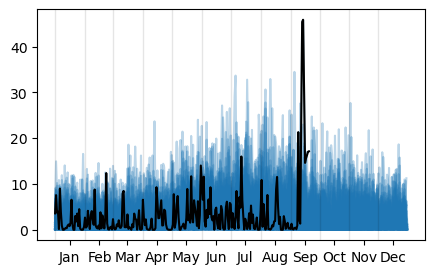

In [14]:
# this time we need to plot each year individually, so we need to make a 'frame' for each line we want to add
fig, ax = plt.subplots(ncols = 1, figsize = (5,3), dpi = 100)

# loop over each year & plot the annual time series
for y in np.unique(ts.time.dt.year):
    ts_y = ts.sel(time = str(y))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)

# add this year in a different colour
ts_y = ts.sel(time = "2024")
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k")

doy_axes()

## How long did the extreme event last for?

In [17]:
ndays = 31

ts_nday = ts.rolling(time = ndays, center = False).sum()

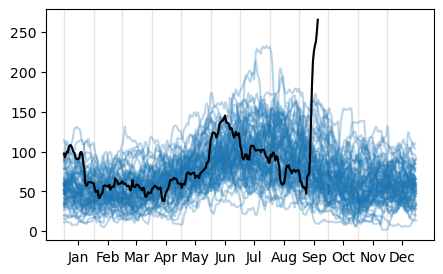

In [18]:
# repeat the plotting per year
fig, ax = plt.subplots(ncols = 1, figsize = (5,3), dpi = 100)

# loop over each year & plot the annual time series
for y in np.unique(ts_nday.time.dt.year):
    ts_y = ts_nday.sel(time = str(y))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)

# add this year in a different colour
ts_y = ts_nday.sel(time = "2024")
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k")

doy_axes()

Text(0.5, 1.0, '31-day running mean')

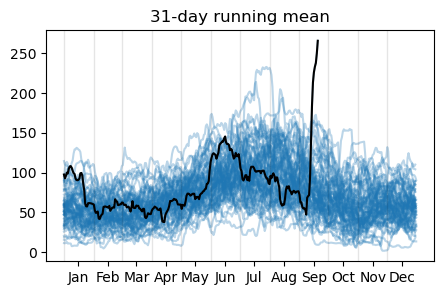

In [19]:
# add a title so we remember that we're looking at a running sum
fig, ax = plt.subplots(ncols = 1, figsize = (5,3), dpi = 100)

# loop over each year & plot the annual time series
for y in np.unique(ts_nday.time.dt.year):
    ts_y = ts_nday.sel(time = str(y))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)

# add this year in a different colour
ts_y = ts_nday.sel(time = "2024")
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k")

doy_axes(ax)
ax.set_title(str(ndays) + "-day running mean")

## Creating an annual time series

### Annual maximum
The easiest way to get an annual time series is to simply take the highest (or in some cases, the lowest) value per year

In [20]:
# recalculate the 3-day running total
ts_nday = ts.rolling(time = 3, center = False).sum()

In [21]:
# get the annual maximum
ts_amax = ts_nday.resample(time = "YS-JAN").max()         # this starts the year in January but you could use eg. "YS-JUL" to start in July and and in June

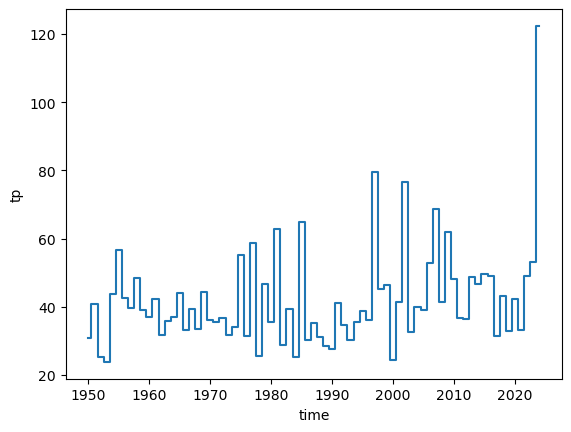

In [22]:
# plot
ts_amax.plot(drawstyle = "steps-mid")

### Annual maximum over selected months
If the event is unusual partly because of the time of year when it occurred, then you might want to look at only a specific month (or months)

In [23]:
# first we choose just the months we're interested in - for example, we might only want to look at the wet season
ts_subset = ts_nday.sel(time = ts_nday.time.dt.month.isin([5,6,7,8,9]))

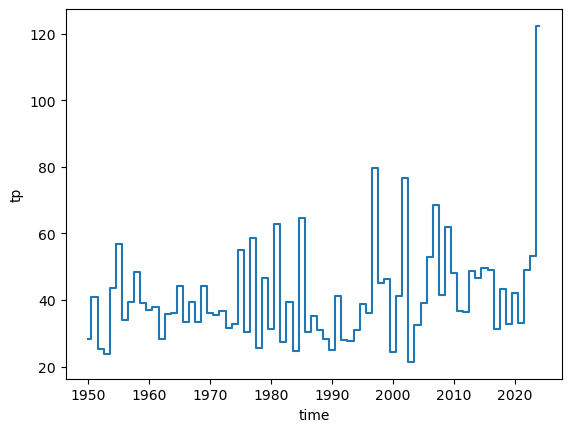

In [24]:
# then we can get the annual maximum like we did before
ts_smax = ts_subset.resample(time = "YS-JAN").max()

ts_smax.plot(drawstyle = "steps-mid")

# Looking at trends

## Rolling mean

We can put a running mean on top of the data to see what the trends look like over time

In [26]:
# compute the 15-year running mean
ts_amax_sm = ts_amax.rolling(time = 15, center = True).mean()

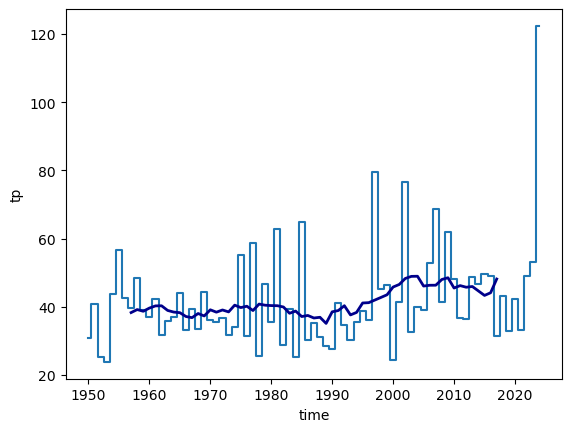

In [27]:
ts_amax.plot(drawstyle = "steps-mid")
ts_amax_sm.plot(color = "darkblue", lw = 2)

## Nonparametric smoothed trend

This is a local nonparametric smoother called a lowess smoother - basically it's a bit like a rolling average but smoother, and you don't have gaps at either end of the series

To get the full range of colours you can use for plotting, look at https://matplotlib.org/stable/gallery/color/named_colors.html

In [29]:
# get the smoothed values: we want to smooth the values over time
ts_amax_np = sm_lowess.lowess(ts_amax, ts_amax.time.dt.year, frac = 2/3)    # 'frac' determines the fraction of the data used to smooth each point - smaller frac means wigglier data (default is 2/3)

# turn the smoothed values back into a dataarray so they're easier to plot
ts_amax_np = xr.DataArray(data = ts_amax_np[:,1], dims = ["time"], name = "z", coords = dict(ts_amax.coords))

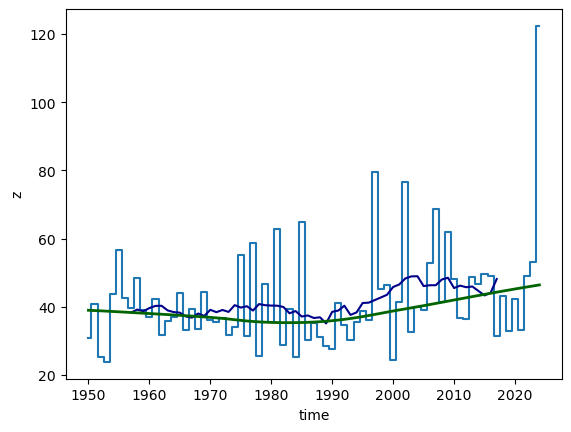

In [30]:
# we can plot both to compare them
ts_amax.plot(drawstyle = "steps-mid")
ts_amax_sm.plot(color = "darkblue")
ts_amax_np.plot(color = "darkgreen", lw = 2)

## Linear trend over time

In [31]:
# fit a linear trend through the data
linear_coeffs = ts_amax.polyfit("time", deg = 1).polyfit_coefficients

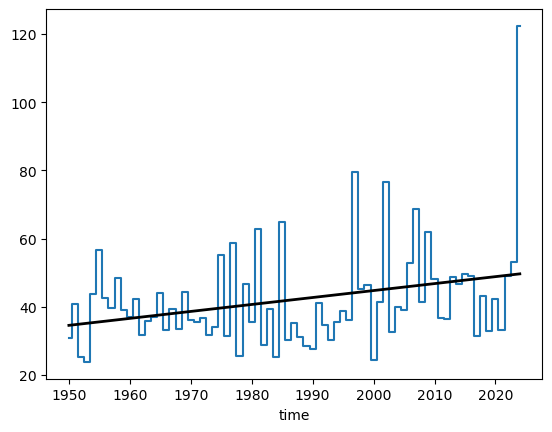

In [32]:
# we can use the estimated coefficients to get the expected temperature in each year, and plot them
fitted_values = xr.polyval(ts_amax.time, linear_coeffs)

ts_amax.plot(drawstyle = "steps-mid")
fitted_values.plot(color = "k", lw = 2)

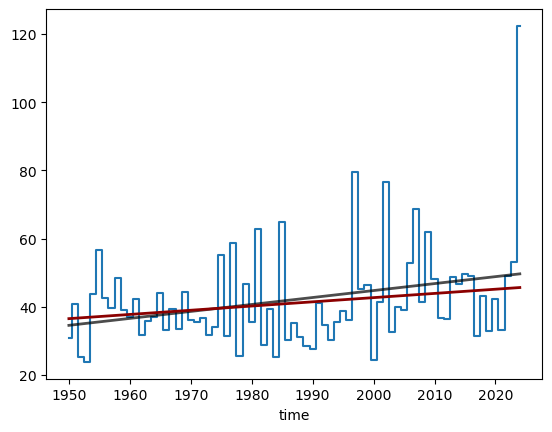

In [33]:
# let's just make sure this isn't just because the 2024 value is really really high
lc_excl2024 = ts_amax.sel(time = slice(None, "2023")).polyfit("time", deg = 1).polyfit_coefficients
fv_excl2024 = xr.polyval(ts_amax.time, lc_excl2024)

ts_amax.plot(drawstyle = "steps-mid")
fitted_values.plot(color = "k", lw = 2, alpha = 0.7)
fv_excl2024.plot(color = "darkred", lw = 2) # still an increasing trend, but lower

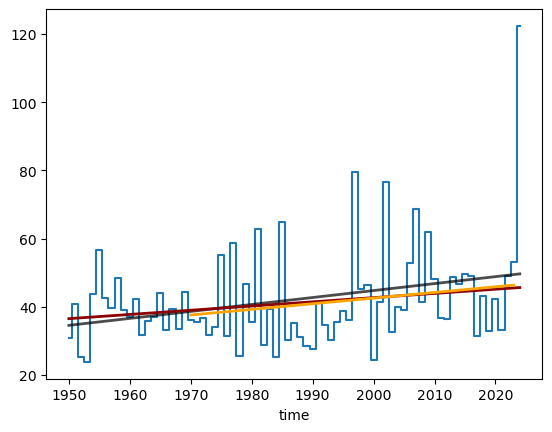

In [34]:
# what if we look at a shorter time period (eg. 1970 onwards)
ts_1970_2023 = ts_amax.sel(time = slice("1970", "2023"))
lc_1970_2023 = ts_1970_2023.polyfit("time", deg = 1).polyfit_coefficients
fv_1970_2023 = xr.polyval(ts_1970_2023.time, lc_1970_2023)

ts_amax.plot(drawstyle = "steps-mid")
fitted_values.plot(color = "k", lw = 2, alpha = 0.7)
fv_excl2024.plot(color = "darkred", lw = 2)              # still an increasing trend, but lower
fv_1970_2023.plot(color = "orange", lw = 2)              # almost no trend over the last 50 years

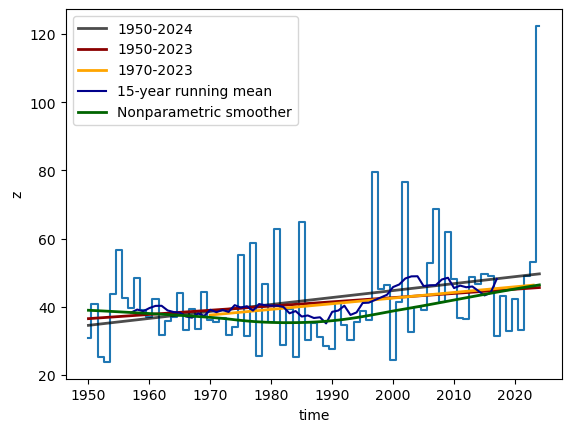

In [73]:
# add a legend so we can tell which line is which
ts_1970_2023 = ts_amax.sel(time = slice("1970", "2023"))
lc_1970_2023 = ts_1970_2023.polyfit("time", deg = 1).polyfit_coefficients
fv_1970_2023 = xr.polyval(ts_1970_2023.time, lc_1970_2023)

# we can add a label to each individual line
ts_amax.plot(drawstyle = "steps-mid")
fitted_values.plot(color = "k", lw = 2, alpha = 0.7, label = "1950-2024")
fv_excl2024.plot(color = "darkred", lw = 2, label = "1950-2023")
fv_1970_2023.plot(color = "orange", lw = 2, label = "1970-2023")

ts_amax_sm.plot(color = "darkblue", label = "15-year running mean")
ts_amax_np.plot(color = "darkgreen", lw = 2, label = "Nonparametric smoother")

# and add a legend showing all the labels
plt.legend()

## Trend dependent on GMST

Unless you're looking at a fairly short period, it's unlikely that any trend will be linear over time (that implies that it changes at a constant rate each year)  
Instead, we can look at how our time series changes as the global mean surface temperature changes

GMST time series can be downloaded from https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.nc

/tmp/ipykernel_19879/571665304.py:43: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ts = ts.assign_coords(time = new_times)


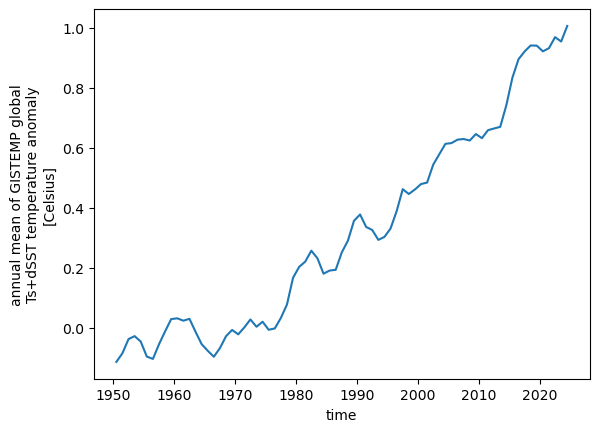

In [35]:
# first, load the GMST time series and select just the period we're interested in
# annual data from the Climate Explorer has weirdly formatted times so we need to decode them manually
gmst = decode_times(xr.open_dataset("igiss_al_gl_a_4yrlo.nc", decode_times = False)).sel(time = slice("1950", "2024")).Ta
gmst.plot()

In [36]:
# fit a linear trend to GMST by replacing time with gmst values
gmst_coeffs = ts_amax.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients

print("Change per 1deg GMST increase: ", gmst_coeffs.sel(degree = 1).round(2).values)

Change per 1deg GMST increase:  13.54


In [37]:
# again, we use the estimated coefficients to get the expected temperature in each year, and plot them
gmst_fitted = xr.polyval(gmst, gmst_coeffs)

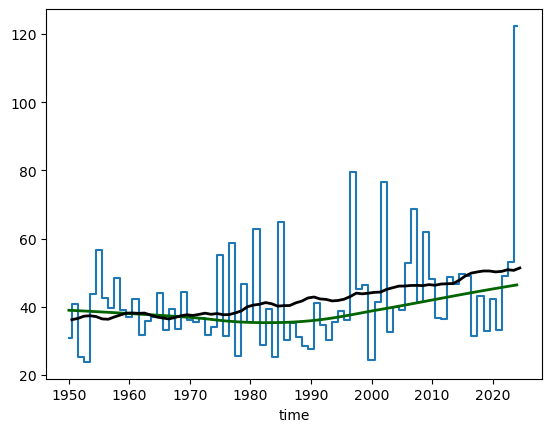

In [38]:
# plot the fitted trend against the obs to see if it makes sense
ts_amax.plot(drawstyle = "steps-mid")
ts_amax_np.plot(color = "darkgreen", lw = 2, label = "Nonparametric smoother")
gmst_fitted.plot(color = "k", lw = 2, label = "GMST trend")

# Other questions you might want to answer

## Was this the wettest day on record?

In [ ]:
# we can sort the values into ascending order and see when the most extreme events occurred
ts_sorted = ts.sortby(ts, ascending = False)

# then we can look at the times when the 10 wettest events occurred
ts_sorted[:10]#.time

In [41]:
ts_sorted[:10].to_dataframe()

tp
time                 
2024-09-14  45.880318
2024-09-13  45.407166
2007-09-06  34.495602
1997-07-07  33.685978
2002-08-12  32.930763
1981-07-19  32.791740
2024-09-15  31.083975
1985-08-07  30.657129
1997-07-06  29.154543
2001-07-20  27.869770

## How many times have we exceeded a particular threshold, and when?

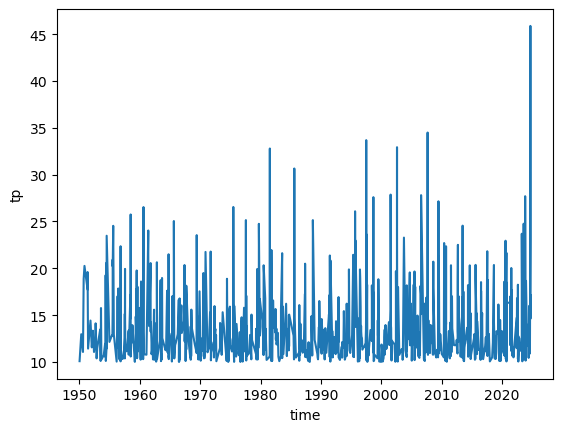

In [43]:
# select just those days that exceed some threshold of interest
wet_days = ts.where(ts >= 10).dropna("time", how = "any")

# the default plot is... not helpful
wet_days.plot()

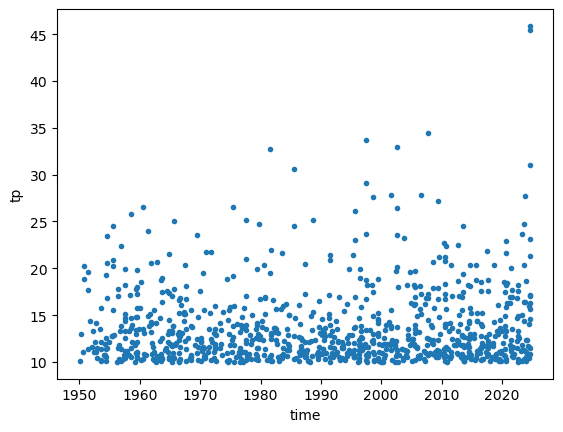

In [44]:
# try plotting as points instead
wet_days.plot(ls = "", marker = ".")

In [ ]:
# we can also look at counts of exceedances each year
n_wetdays = wet_days.resample(time = "YS-JAN").count()

plt.bar(x = n_wetdays.time.dt.year, height = n_wetdays)

# Create a time series that can be uploaded to the climate explorer

In [82]:
ts_amax.assign_coords(time = ts_amax.time.dt.year).rename(time = "#year").to_dataframe().to_csv("annual-time-series-for-climexp.csv", sep = " ")

# then find the file and 'open with editor', select all & copy
# sign in to climate explorer, go to 'view, upload your time series'
# delete the text in the big box in the 'upload text data' section, and paste your data in instead
# give it a meaningful name in the box above
# the first line should start '# year' (and then a variable name)
# each row should have a year and one value, with a space in between
# it has to be years, dates won't work
# when it all looks fine, press 'upload'
# now you can work with your time series as if you'd 